In [1]:
import sys, os
import pandas as pd
import numpy as np
import random

from sklearn import metrics
from scipy import stats
# from flaml import AutoML # https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML/
from tqdm import tqdm

import torch
torch.manual_seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress

In [2]:
interaction_df = pd.read_csv("/work3/s232958/data/data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).drop(columns = ["binder_id", "target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


In [3]:
meta_binders_encodings_path = "/work3/s232958/data/data/meta_analysis/binders_embeddings"
meta_binders_files = sorted(os.listdir(meta_binders_encodings_path))  # keep files & embeddings aligned
meta_binders = [file.split(".")[0] for file in meta_binders_files]
meta_binders_embedings = [np.load(os.path.join(meta_binders_encodings_path, f))[0] for f in meta_binders_files]

meta_targets_embedings_path = "/work3/s232958/data/data/meta_analysis/targets_embeddings"
meta_targets_files = sorted(os.listdir(meta_targets_embedings_path))  # keep files & embeddings aligned
meta_targets = [file.split(".")[0] for file in meta_targets_files]
meta_targets_embedings = [np.load(os.path.join(meta_targets_embedings_path, f))[0] for f in meta_targets_files]

In [4]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"],
]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [5]:
# binder_id : target_id
binder_target_Dict = dict(zip(interaction_df.target_binder_ID, interaction_df.target_id_mod))

# binder_id : label
binder_lbl = dict(zip(interaction_df.target_binder_ID, interaction_df.binder))

# assigning index/number to target (for later)
target_idx = {target: idx for idx, target in enumerate(meta_targets)}

# all binders (list) but id is target id
targets_per_binder = [binder_target_Dict[b] for b in meta_binders]

# all binders (list) but id is target number
groups_all = np.array([target_idx[t] for t in targets_per_binder])

# existing features/labels aligned to meta_binders
binders_emb = [b.mean(axis=0) for b in meta_binders_embedings]
targets_emb = [meta_targets_embedings[target_idx[t]].mean(axis=0) for t in targets_per_binder]
labels = [binder_lbl[b] for b in meta_binders]

- mean pooling so that all sequence embeddings are represented by single vector dimenssion (1152, )
- `np.concatenate([smth1, smth2], axis=0).shape --> (2304,)`
- stack all the concatenated entries

In [6]:
smth1 = binders_emb[1]
smth2 = targets_emb[1]
np.concatenate([smth1, smth2], axis=0).shape

def build_Xy(binders, targets, labels_):
    # np.concatenate([binders[i], targets[i]], axis=0).shape --> (2304,)
    X = np.stack([np.concatenate([binders[i], targets[i]], axis=0) for i in range(len(binders))], axis=0)
    y = np.array(labels_)
    return X, y

In [7]:
CV_Folds = {}

for idx, (val_t, train_t) in enumerate(cv_splits):
    # masks based on target IDs aligned to meta_binders
    mask_val = [t in val_t for t in targets_per_binder]
    mask_train = [t in train_t for t in targets_per_binder]

    # split features/labels
    val_binders = list(compress(binders_emb, mask_val))
    val_targets = list(compress(targets_emb, mask_val))
    val_labels = list(compress(labels, mask_val))

    train_binders = list(compress(binders_emb, mask_train))
    train_targets = list(compress(targets_emb, mask_train))
    train_labels = list(compress(labels, mask_train))

    # build arrays
    train_X, train_y = build_Xy(train_binders, train_targets, train_labels)
    val_X, val_y = build_Xy(val_binders, val_targets, val_labels)

    # groups (for later use in FLAML)
    groups_train = np.array(list(compress(groups_all, mask_train)))
    # groups_val   = np.array(list(compress(groups_all, mask_val)))

    CV_Folds[idx] = {
        "X_train": (train_X, train_y),
        "X_val":   (val_X,   val_y),
        "groups_train": groups_train
    }

In [8]:
assert len(CV_Folds[4]["groups_train"]) == len(CV_Folds[4]["X_train"][0])
print(len(CV_Folds[4]["X_train"][0]))
print(len(CV_Folds[4]["groups_train"]))

3371
3371


In [9]:
CV_Folds[0]["X_train"]

(array([[-0.01337376, -0.01022492, -0.0313263 , ..., -0.01029722,
          0.00293329, -0.00713582],
        [-0.01928971, -0.01759399, -0.02778696, ..., -0.01029722,
          0.00293329, -0.00713582],
        [-0.00362143, -0.0006471 , -0.0078205 , ..., -0.01029722,
          0.00293329, -0.00713582],
        ...,
        [-0.00649736, -0.00637164, -0.01982584, ..., -0.00340336,
          0.00842065, -0.0062203 ],
        [-0.00985113,  0.00682535, -0.01472657, ..., -0.00340336,
          0.00842065, -0.0062203 ],
        [-0.00274678, -0.00047976, -0.01324974, ..., -0.00340336,
          0.00842065, -0.0062203 ]], dtype=float32),
 array([False, False, False, ...,  True,  True,  True]))

### AutoML "classification" was run optimizing on metirc "ap"

In [10]:
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning,
    module="sklearn",
)

CV_BestModels = {}

for i in tqdm(range(len(CV_Folds)), desc="Outer CV folds"):
    # unpack
    X_train, y_train = CV_Folds[i]["X_train"]
    X_val,   y_val   = CV_Folds[i]["X_val"]
    groups_train     = CV_Folds[i]["groups_train"]

    automl = AutoML()
    settings = {
        "time_budget": 500,
        "task": "classification",
        "metric": "ap", # 'ap': minimize 1 - average_precision_score.
        "verbose": 1,
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": "group",
        "groups": groups_train,
    }
    automl.fit(X_train=X_train, y_train=y_train, **settings)

    # predicted labels -> use for accuracy
    y_pred = automl.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    # probabilities -> use for AP/AUROC
    classes_ = getattr(automl, "classes_", np.unique(y_train))
    if hasattr(automl, "predict_proba"):
        y_proba = automl.predict_proba(X_val)
        # ensure we take the positive-class probability
        # prefer label 1 if present; else use the larger label
        pos_label = 1 if 1 in classes_ else classes_[-1]
        pos_idx = list(classes_).index(pos_label)
        y_score = y_proba[:, pos_idx]
    else:
        # fallback: make a pseudo-prob from labels (not ideal, but avoids crashes)
        pos_label = 1 if 1 in classes_ else classes_[-1]
        y_score = (y_pred == pos_label).astype(float)

    ap = average_precision_score(y_val, y_score)
    auroc = roc_auc_score(y_val, y_score)

    CV_BestModels[i] = {
        "estimator": automl.best_estimator,
        "best_config": automl.best_config,
        "loss": automl.best_loss,
        "accuracy": acc,
        "ap": ap,
        "auroc": auroc,
    }

Outer CV folds: 100%|████████████████████████████████████████████████████████████████████| 5/5 [43:01<00:00, 516.33s/it]


In [11]:
CV_BestModels

{0: {'estimator': 'extra_tree',
  'best_config': {'n_estimators': 4,
   'max_features': 0.08348582988897457,
   'max_leaves': 4,
   'criterion': 'entropy'},
  'loss': 0.7974542001624136,
  'accuracy': 0.10523978685612789,
  'ap': 0.0954115075303501,
  'auroc': 0.40068312457317157},
 1: {'estimator': 'sgd',
  'best_config': {'penalty': 'None',
   'alpha': 7.043833655822719e-05,
   'l1_ratio': 0.9999999999999999,
   'epsilon': 0.021433488901926104,
   'learning_rate': 'constant',
   'eta0': 0.008545802523139287,
   'power_t': 0.5291074369939103,
   'average': False,
   'loss': 'modified_huber'},
  'loss': 0.7752582821035963,
  'accuracy': 0.8307210031347962,
  'ap': 0.18666469869874822,
  'auroc': 0.5010132774283718},
 2: {'estimator': 'xgboost',
  'best_config': {'n_estimators': 4,
   'max_leaves': 4,
   'min_child_weight': 0.18801229216129597,
   'learning_rate': 0.230677497902749,
   'subsample': 0.9084756131881826,
   'colsample_bylevel': 0.6213391014442057,
   'colsample_bytree': 0.

In [12]:
for i, j in CV_BestModels.items():
    print(f"Fold{i+1}, estimator: {j['estimator']}")
    print("\t", "accuracy:", round(j['accuracy'], 3))
    print("\t", "ap:", round(j['ap'], 3))
    print("\t", "auroc:", round(j['auroc'], 3))

Fold1, estimator: extra_tree
	 accuracy: 0.105
	 ap: 0.095
	 auroc: 0.401
Fold2, estimator: sgd
	 accuracy: 0.831
	 ap: 0.187
	 auroc: 0.501
Fold3, estimator: xgboost
	 accuracy: 0.884
	 ap: 0.106
	 auroc: 0.453
Fold4, estimator: xgboost
	 accuracy: 0.931
	 ap: 0.103
	 auroc: 0.479
Fold5, estimator: extra_tree
	 accuracy: 0.888
	 ap: 0.101
	 auroc: 0.441


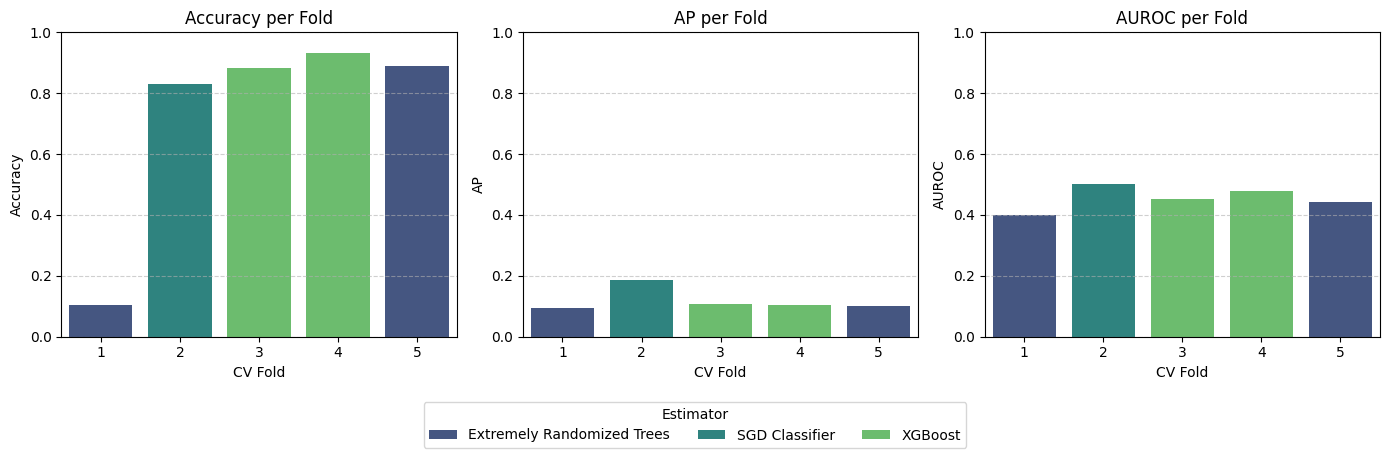

In [4]:
# Data Preparation
df = pd.DataFrame({
    'CV Fold': [1, 2, 3, 4, 5],
    'Estimator': ["Extremely Randomized Trees", "SGD Classifier", "XGBoost", "XGBoost", "Extremely Randomized Trees"],
    'Accuracy': [0.105, 0.831, 0.884, 0.931, 0.888],
    'AP': [0.095, 0.187, 0.106, 0.103, 0.101],
    'AUROC': [0.401, 0.501, 0.453, 0.479, 0.441]
})

# Setup for subplots
metrics = ['Accuracy', 'AP', 'AUROC']
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
palette = sns.color_palette("viridis", n_colors=len(df['Estimator'].unique()))

for i, metric in enumerate(metrics):
    sns.barplot(
        data=df, x='CV Fold', y=metric, hue='Estimator', 
        palette=palette, ax=axes[i], dodge=False
    )
    axes[i].set_title(f'{metric} per Fold')
    axes[i].set_ylim(0, 1.0)
    axes[i].grid(axis='y', linestyle='--', alpha=0.6)
    axes[i].get_legend().remove() # Hide individual legends

# Single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Estimator', loc='lower center', 
           bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.savefig('fold_performance.png', bbox_inches='tight')

# Bad :)

### AutoML "classification" was run optimizing on metirc "auroc"

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names",
    category=UserWarning,
    module="sklearn",
)

CV_BestModels2 = {}

for i in tqdm(range(len(CV_Folds)), desc="Outer CV folds"):
    # unpack
    X_train, y_train = CV_Folds[i]["X_train"]
    X_val,   y_val   = CV_Folds[i]["X_val"]
    groups_train     = CV_Folds[i]["groups_train"]

    automl = AutoML()
    settings = {
        "time_budget": 500,
        "task": "classification",
        "metric": "roc_auc", # 'roc_auc': minimize 1 - roc_auc_score. Default metric for binary classification.
        "verbose": 1,
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": "group",
        "groups": groups_train,
    }
    automl.fit(X_train=X_train, y_train=y_train, **settings)

    # predicted labels -> use for accuracy
    y_pred = automl.predict(X_val)
    acc = accuracy_score(y_val, y_pred)

    # probabilities -> use for AP/AUROC
    classes_ = getattr(automl, "classes_", np.unique(y_train))
    if hasattr(automl, "predict_proba"):
        y_proba = automl.predict_proba(X_val)
        # ensure we take the positive-class probability
        # prefer label 1 if present; else use the larger label
        pos_label = 1 if 1 in classes_ else classes_[-1]
        pos_idx = list(classes_).index(pos_label)
        y_score = y_proba[:, pos_idx]
    else:
        # fallback: make a pseudo-prob from labels (not ideal, but avoids crashes)
        pos_label = 1 if 1 in classes_ else classes_[-1]
        y_score = (y_pred == pos_label).astype(float)

    ap = average_precision_score(y_val, y_score)
    auroc = roc_auc_score(y_val, y_score)

    CV_BestModels2[i] = {
        "estimator": automl.best_estimator,
        "best_config": automl.best_config,
        "loss": automl.best_loss,
        "accuracy": acc,
        "ap": ap,
        "auroc": auroc,
    }

Outer CV folds:   0%|                                                                             | 0/5 [00:00<?, ?it/s]

In [ ]:
CV_BestModels2

In [ ]:
for i, j in CV_BestModels.items():
    print(f"Fold{i+1}, estimator: {j['estimator']}")
    print("\t", "accuracy:", round(j['accuracy'], 3))
    print("\t", "ap:", round(j['ap'], 3))
    print("\t", "auroc:", round(j['auroc'], 3))

# Bad :)